In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import ndimage as ndi

# NOTE: We are using Scikit-Image version 0.18.3
# If you have a version different from that, plase open you Anaconda prompt and type:
# conda install -c anaconda scikit-image=0.18.3

from skimage.io import imread
from skimage.filters import gabor_kernel
from skimage.util import invert
from skimage.exposure import equalize_adapthist

# custom functions
from utils.blockproc import blockproc

In [15]:
def gabor_filtering(img, fi):
    # 'mode' specifies how the convolution algorithm will deal with the borders
    If1 = equalize_adapthist(ndi.convolve(img, fi, mode='wrap'))
    # normalize
    If1 = ((If1 - np.min(If1)) / (np.max(If1) - np.min(If1))) * 255
    #print(np.min(If1), np.max(If1))
    
    return If1

# create the filter according to the size of the image
def gabor_template(im, angle, freq=0.11):
    r, c = im.shape
    ysize = int(np.floor(r/10))

    t = int(np.floor(ysize/8))
    fi = np.real(gabor_kernel(freq, theta=angle, n_stds=t))
    
    return fi

## Exercise 1

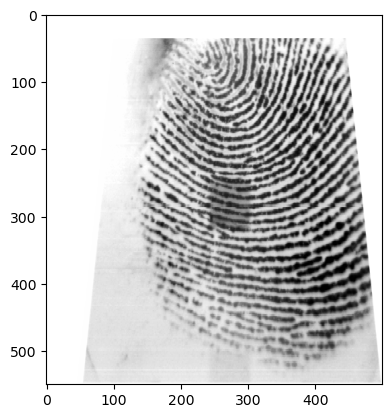

In [16]:
# the image loaded is already [0,1]
img = imread(f'fingerprints/r1.bmp', as_gray=True)
plt.imshow(img, cmap='gray');

using angle 0.7853981633974483, freq=0.15


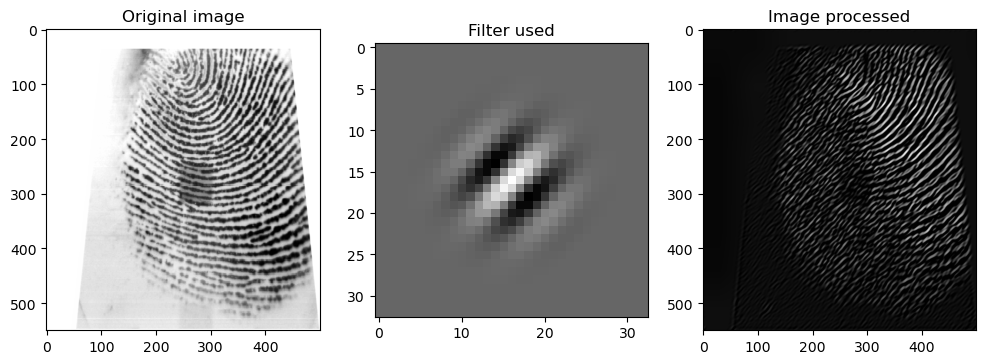

using angle 0.7853981633974483, freq=0.08


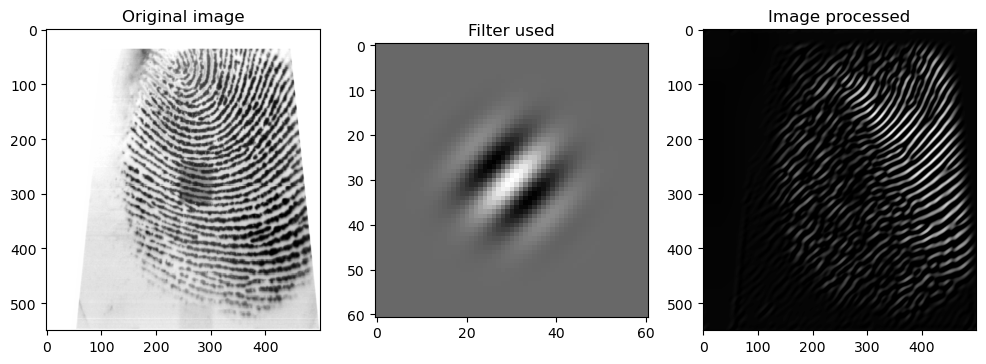

using angle 1.5707963267948966, freq=0.1


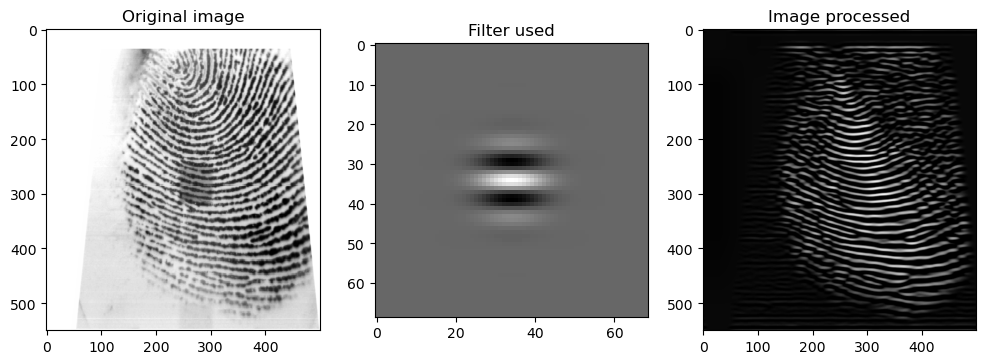

using angle 3.141592653589793, freq=0.1


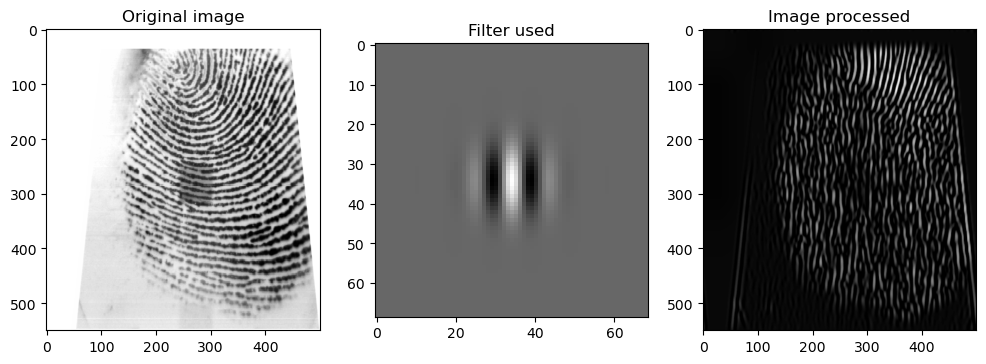

In [17]:
param_set = [(np.pi/4, 0.15),(np.pi/4,0.08),(np.pi/2,0.10),(np.pi,0.10)]
for param in param_set: 
    fi = gabor_template(img, angle=param[0], freq=param[1])
    img_f = gabor_filtering(img, fi)
    print(f"using angle {param[0]}, freq={param[1]}")
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap='gray'); plt.title('Original image')
    plt.subplot(1,3,2)
    plt.imshow(fi, cmap='gray'); plt.title('Filter used')
    plt.subplot(1,3,3)
    plt.imshow(img_f, cmap='gray'); plt.title('Image processed');
    plt.show()

## Exercise 2

In [2]:
import cv2 as cv
import numpy as np

from skimage.io import imread, imsave
from skimage.util import img_as_ubyte, invert
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage.filters import median, gaussian

from utils.poincare import calculate_singularities
from utils.segmentation import segmentation
from utils.normalization import normalize
from utils.gabor_filter import gabor_filter
from utils.frequency import ridge_freq
from utils.orientation import calculate_angles, visualize_angles
from utils.crossing_number import calculate_minutiae
from utils.skeletonize import skeletonize
from utils.align2 import align2
from utils.MatchGaborFeat import MatchGaborFeat
from utils.align2 import align2
from utils.match import match

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from utils.MatchGaborFeat import MatchGaborFeat

In [4]:
def fingerprint_processing(img, block_size=16, threshold=0.4):
    output = {}
    
    # normalization - removes the effects of sensor noise and finger pressure differences.
    normalized_img = normalize(img.copy(), float(100), float(100))
    output['normalized_img'] = normalized_img
    
    # segmentation
    (segmented_img, normim, mask) = segmentation(normalized_img, 
                                                 block_size, 
                                                 threshold)
    output['segmented_img'] = segmented_img
    output['normim'] = normim
    output['mask'] = mask
    
    # orientation estimation
    angles = calculate_angles(normalized_img, 
                              W=block_size, smooth=True)
    output['angles'] = angles
    
    # find the overall frequency of ridges
    freq = ridge_freq(normim, mask, angles, 
                      block_size, kernel_size=5, 
                      minWaveLength=5, maxWaveLength=15)
    output['freq'] = freq
    
    # create gabor filter and do the actual filtering
    gabor_img = gabor_filter(normim, angles, freq, block_size)
    output['gabor_img'] = gabor_img
    
    # create the skeleton
    thin_image = skeletonize(gabor_img)
    output['thin_image'] = thin_image
    
    # find the minutiae
    minutiae_lst, minutiae_img, minutiae_arr = calculate_minutiae(thin_image, mask)
    output['minutiae_lst'] = minutiae_lst
    output['minutiae_img'] = minutiae_img
    output['minutiae_array'] = minutiae_arr
    
    # singularities
    singularities_lst, singularities_img = calculate_singularities(thin_image, 
                                                                   angles, block_size, 
                                                                   mask)
    output['singularities_lst'] = singularities_lst
    output['singularities_img'] = singularities_img
    
    return output

In [5]:
gallery = []
for i in range(1,10):
    img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
    fp = fingerprint_processing(img, block_size=12, threshold=0.1)
    gallery.append(fp)    
    
print("gallery initialization completed")    

gallery initialization completed


In [6]:
probe_img = img_as_ubyte(imread('fingerprints/r10.bmp', as_gray=True))
probe_fp = fingerprint_processing(probe_img, block_size=12, threshold=0.1)

In [9]:
score_array = []
for i in range(0,len(gallery)):
    print(f"matching with gallery index {i}")
    print(gallery[i])
    print("------")
    print(probe_fp)
#     imSkeletonAlign, minutiaArrayAlign = align2(gallery[i], probe_fp)
#     probe_fp['imSkeletonAlign'] = imSkeletonAlign
#     probe_fp['minutiaArrayAlign'] = minutiaArrayAlign

#     match_threshold = 6
#     score = match(gallery[i], probe_fp, threshold2=match_threshold)
#     score_array.append(score)
#     print('score for minutiae: %.4f\n' % (score))

matching with gallery index 0
{'normalized_img': array([[109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109],
       [109, 109, 109, ..., 109, 109, 109],
       ...,
       [109, 109, 109, ..., 104, 106, 109],
       [109, 109, 109, ..., 108, 108, 109],
       [109, 109, 109, ..., 108, 108, 108]], dtype=uint8), 'segmented_img': array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 104, 106, 109],
       [  0,   0,   0, ..., 108, 108, 109],
       [  0,   0,   0, ..., 108, 108, 108]], dtype=uint8), 'normim': array([[ 0.75520016,  0.75520016,  0.75520016, ...,  0.75520016,
         0.75520016,  0.75520016],
       [ 0.75520016,  0.75520016,  0.75520016, ...,  0.75520016,
         0.75520016,  0.75520016],
       [ 0.75520016,  0.75520016,  0.75520016, ...,  0.75520016,
         0.75520016,  0.75520016],
       ...,
       [ 0.75520016,  0.755200

In [ ]:
for i in range(0,len(gallery)):
    print(f"matching with gallery index {i}")
    imSkeletonAlign, minutiaArrayAlign = align2(gallery[i], probe_fp)
    probe_fp['imSkeletonAlign'] = imSkeletonAlign
    probe_fp['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(gallery[i], probe_fp, threshold2=match_threshold)
    print('score for minutiae: %.4f\n' % (score))

## Exercise 3

In [ ]:
from skimage.util import img_as_ubyte
from skimage.io import imread
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt

from utils.MatchGaborFeat import MatchGaborFeat

In [ ]:
score_array = []
probe_img = img_as_ubyte(imread('fingerprints/r10.bmp', as_gray=True))
for i in range(1,10):
    print(f"matching with gallery index {i}")
    gallery_img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
    score = MatchGaborFeat(gallery_img, probe_img, plot_res=True)
    score_array.append(score)
    print('Score using Gabor features: %.4f' % (score))


## Exercise 4

In [ ]:
gallery = []
prob_img = img_as_ubyte(imread(f'fingerprints/l3.bmp', as_gray=True))
prob_fp = fingerprint_processing(prob_img, block_size=12, threshold=0.1)
for i in range(1,11):
    img = img_as_ubyte(imread(f'fingerprints/r{i}.bmp', as_gray=True))
    fp = fingerprint_processing(img, block_size=12, threshold=0.1)
    gallery.append(fp)    

left_img  = img_as_ubyte(imread(f'fingerprints/l6.bmp', as_gray=True))
left_fp = fingerprint_processing(left_img, block_size=12, threshold=0.1)
gallery.append(left_fp)    
print("gallery initialization completed")    

In [ ]:
scores = {}
for i in range(0,len(gallery)):
    print(f"matching with gallery index {i}")
    imSkeletonAlign, minutiaArrayAlign = align2(gallery[i], probe_fp)
    probe_fp['imSkeletonAlign'] = imSkeletonAlign
    probe_fp['minutiaArrayAlign'] = minutiaArrayAlign

    match_threshold = 6
    score = match(gallery[i], probe_fp, threshold2=match_threshold)
    score[i] = score
    print('score for minutiae: %.4f\n' % (score))

In [ ]:
sorted_scores = dict(sorted(scores.items(), key=lambda item: item[1]))
for k,v in sorted_scores:
    print(f"index: {k} value:{v}")